# Students: Lilach Pardess & Assaf Taubenfeld

# Homework 2: Multiclass Classification with PyTorch

In this assignment, you will build, train, and evaluate a neural network for multiclass classification using PyTorch.
You will use the [Garbage dataset](https://www.kaggle.com/datasets/mostafaabla/garbage-classification).
The goal is to gain hands-on experience with:
- Dataset preparation 
- Building two  PyTorch models
- Loss functions for multiclass
- Training loop and evaluation
- Visualize of performance

# Students: Lilach Pardess & Assaf Taubenfeld

## About Dataset
### Context
This dataset has 15,150 images from 12 different classes of household garbage; paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash.

Garbage Recycling is a key aspect of preserving our environment. To make the recycling process possible/easier, the garbage must be sorted to groups that have similar recycling process. I found that most available data sets classify garbage into a few classes (2 to 6 classes at most). Having the ability to sort the household garbage into more classes can result in dramatically increasing the percentage of the recycled garbage.

### Content
An ideal setting for data collection would be to place a camera above a conveyor where the garbage comes one by one, so that the camera can capture real garbage images. But since such a setup is not feasible at the moment I collected most of the images in this dataset by web scraping, I tried to get images close to garbage images whenever possible, for example in biological garbage category I searched for rotten vegetables, rotten fruits and food remains, etc. However, for some classes such as clothes or shoes it was more difficult to get images of clothes or shoes from the garbage, so mostly it was images of normal clothes. Nevertheless, being able to classify the images of this data set to 12 classes can be a big step towards improving the recycling process.

### Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
import kagglehub
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import os
import torch.nn.functional as F
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms


torch.manual_seed(42)
# %matplotlib inline

### Dwonload and prepare dataset from kagglehub
`kagglehub.dataset_download` downloads and extracts Kaggle datasets to a local cache directory (usually under `~/.cache/kagglehub/datasets/`). It returns the path to the unzipped dataset, preserving the original folder structure as found on Kaggle, such as one subfolder per class for image datasets.

---

### **What is the structure of the downloaded content?**

* Inside the returned directory (`path`), you will find the files and folders as originally organized on Kaggle.
* For the **garbage classification** dataset, you typically get a folder like:

  ```
  garbage_classification/
      cardboard/
      glass/
      metal/
      paper/
      plastic/
      trash/
      ...
  ```

  Each subfolder contains images belonging to that class (a classic structure for use with `torchvision.datasets.ImageFolder`).


In [5]:
# Download the latest version of the Kaggle dataset to a local directory
path = kagglehub.dataset_download("mostafaabla/garbage-classification",)

# Set the data directory to the location of the downloaded images
data_dir = os.path.join(path, "garbage_classification")

# Set the desired image size for resizing
img_size = 64

# Define the image transformations to apply to each image:
# - Resize the image to (img_size, img_size)
# - Convert the image to a PyTorch tensor
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize images
    transforms.ToTensor()                     # Convert to tensor
])  

print(f"image transform: {transform}")

image transform: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
dataset  = ImageFolder(root=data_dir, transform=transform)

classes_names = dataset.classes
# dataset = ImageFolder(data_dir + '/Training', transform=transform)
print("Number of images:", len(dataset), "number of classes:", len(classes_names))
print("Class names:", classes_names)


Number of images: 15515 number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


### TODO 1:
Create a 4×3 subplot that displays one example image from each category in the dataset.


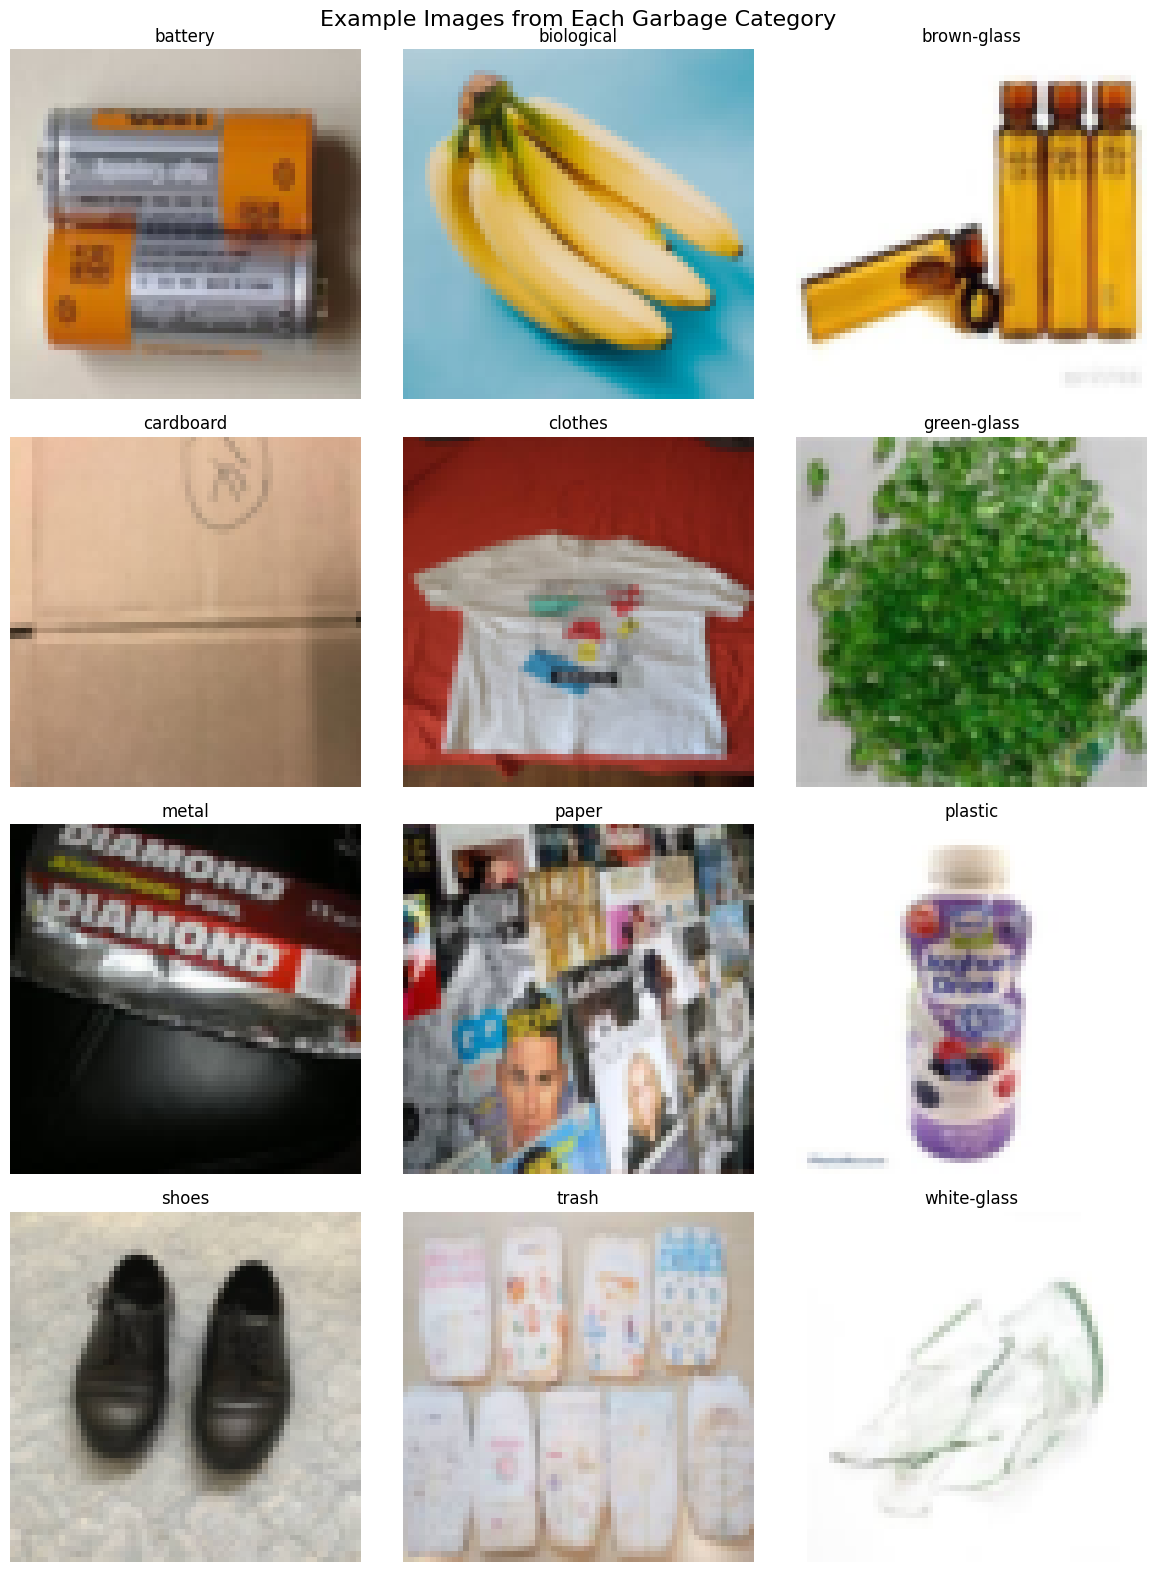

In [7]:
# Create a 4x3 subplot to display one example from each category
fig, axes = plt.subplots(4, 3, figsize=(12, 16))
fig.suptitle('Example Images from Each Garbage Category', fontsize=16)

# Get one example from each class
examples_per_class = {}
for idx, (image, label) in enumerate(dataset):
    class_name = classes_names[label]
    if class_name not in examples_per_class:
        examples_per_class[class_name] = (image, label)
    # Stop when we have one example from each class
    if len(examples_per_class) == len(classes_names):
        break

# Plot the examples
for i, class_name in enumerate(classes_names):
    row = i // 3
    col = i % 3
    
    image, label = examples_per_class[class_name]
    # Convert tensor to numpy and transpose for matplotlib (C, H, W) -> (H, W, C)
    img_np = image.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img_np)
    axes[row, col].set_title(f'{class_name}', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


### TODO 2:
Shuffle the dataset and split it into training and validation sets, using 80% of the samples for training and 20% for validation. Make sure that the class distribution is preserved as much as possible in both splits.


In [8]:
import numpy as np
from collections import defaultdict, Counter
from torch.utils.data import Subset

train_ratio = 0.8

#1. Split the dataset into a dictionary of  lists, keyed by label (class)
# indices are a list of indexs in the original dataset
class_to_indices_map = defaultdict(list)
for idx, (image, label) in enumerate(dataset):
    class_to_indices_map[label].append(idx)

train_indices = []
val_indices = []

#2. Split each list from the dictionary into train, validation and test sets
for class_name, indices in class_to_indices_map.items():
    np.random.shuffle(indices)

    split_index = int(len(indices) * train_ratio)
    # Extend the train and val indices set, with the indexs of the items from the current class
    train_indices.extend(indices[:split_index])
    val_indices.extend(indices[split_index:])

#3. Shuffle the train and validation indices, to mix the classes data
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)

#4. Create the Touch Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

#5. Verify that the split preserves the class distribution
train_labels = [dataset[i][1] for i in train_indices]
val_labels = [dataset[i][1] for i in val_indices]

train_distribution = Counter(train_labels)
val_distribution = Counter(val_labels)

for class_name, indices in class_to_indices_map.items():
    class_ratio = len(indices) / len(dataset)
    train_class_ratio = 0
    for train_class_name, count in train_distribution.items():
        if class_name == train_class_name:
            train_class_ratio = count / len(train_dataset)
    val_class_ratio = 0
    for val_class_name, count in val_distribution.items():
        if class_name == val_class_name:
            val_class_ratio = count / len(val_dataset)
    print(
        f"Class: {class_name}, Count: {len(indices)}, Dataset Raion: {class_ratio} Train ratio: {train_class_ratio}, Validation ratio: {val_class_ratio}"
    )



Class: 0, Count: 945, Dataset Raion: 0.06090879793747986 Train ratio: 0.060923523249254576, Validation ratio: 0.06084996780424984
Class: 1, Count: 985, Dataset Raion: 0.06348694811472769 Train ratio: 0.06350229672012249, Validation ratio: 0.06342562781712814
Class: 2, Count: 607, Dataset Raion: 0.03912342893973574 Train ratio: 0.03908453541784189, Validation ratio: 0.039278815196394076
Class: 3, Count: 891, Dataset Raion: 0.0574282951981953 Train ratio: 0.05737770972681119, Validation ratio: 0.05763039278815196
Class: 4, Count: 5325, Dataset Raion: 0.34321624234611664 Train ratio: 0.34329921830929166, Validation ratio: 0.3428847392144237
Class: 5, Count: 629, Dataset Raion: 0.040541411537222044 Train ratio: 0.04053509549520509, Validation ratio: 0.04056664520283323
Class: 6, Count: 769, Dataset Raion: 0.04956493715758943 Train ratio: 0.04956080264324281, Validation ratio: 0.049581455247907275
Class: 7, Count: 1050, Dataset Raion: 0.0676764421527554 Train ratio: 0.06769280361028286, Val

### TODO 3:
Visualize the class distribution in both the training and validation sets using a bar plot, so you can compare how well the splits represent the overall dataset.


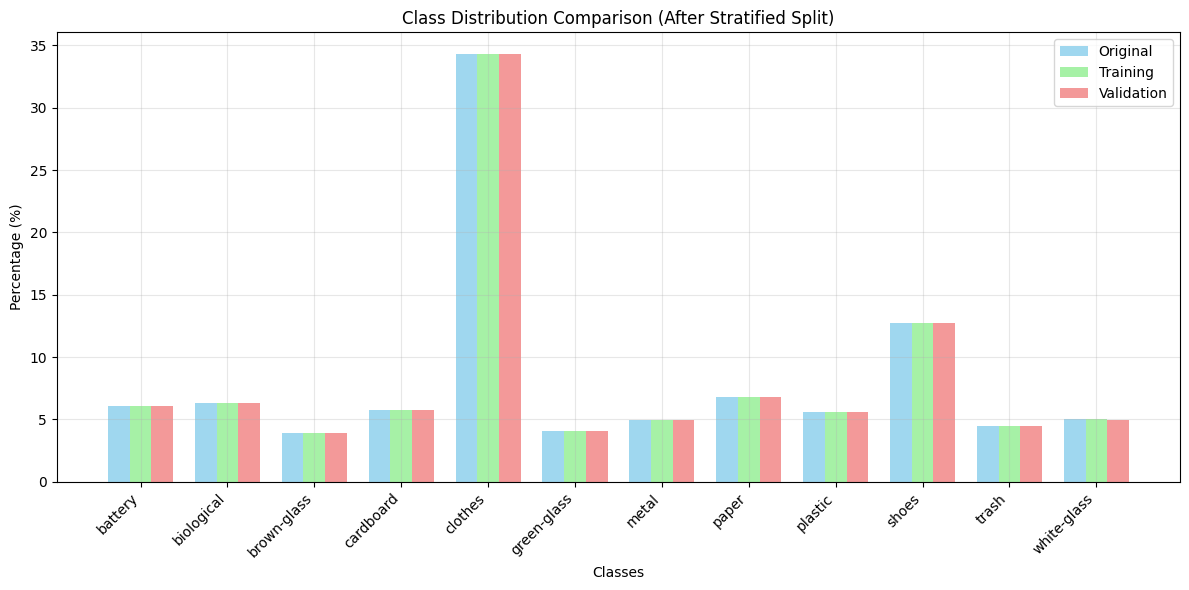

In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distributions(original_labels, train_labels, val_labels, classes_names, title_suffix=""):
    """
    Create a simple bar plot comparing class distributions across original, train, and validation sets.
    
    Args:
        original_labels: List of all labels from original dataset
        train_labels: List of labels from training set
        val_labels: List of labels from validation set  
        classes_names: List of class names for labeling
        title_suffix: Optional suffix to add to plot title
    """
    
    # Calculate percentage distributions
    original_counts = Counter(original_labels)
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    
    # Convert to percentages in class order
    original_percentages = [original_counts[i]/len(original_labels)*100 for i in range(len(classes_names))]
    train_percentages = [train_counts[i]/len(train_labels)*100 for i in range(len(classes_names))]
    val_percentages = [val_counts[i]/len(val_labels)*100 for i in range(len(classes_names))]
    
    # Create single bar plot
    x = np.arange(len(classes_names))
    width = 0.25
    
    plt.figure(figsize=(12, 6))
    plt.bar(x - width, original_percentages, width, label='Original', alpha=0.8, color='skyblue')
    plt.bar(x, train_percentages, width, label='Training', alpha=0.8, color='lightgreen')
    plt.bar(x + width, val_percentages, width, label='Validation', alpha=0.8, color='lightcoral')
    
    plt.title(f'Class Distribution Comparison{title_suffix}')
    plt.xlabel('Classes')
    plt.ylabel('Percentage (%)')
    plt.xticks(x, classes_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function with current distributions
original_labels = train_labels + val_labels
plot_class_distributions(
    original_labels=original_labels,
    train_labels=train_labels, 
    val_labels=val_labels,
    classes_names=classes_names,
    title_suffix=" (After Stratified Split)"
)

Converged after 7 iterations


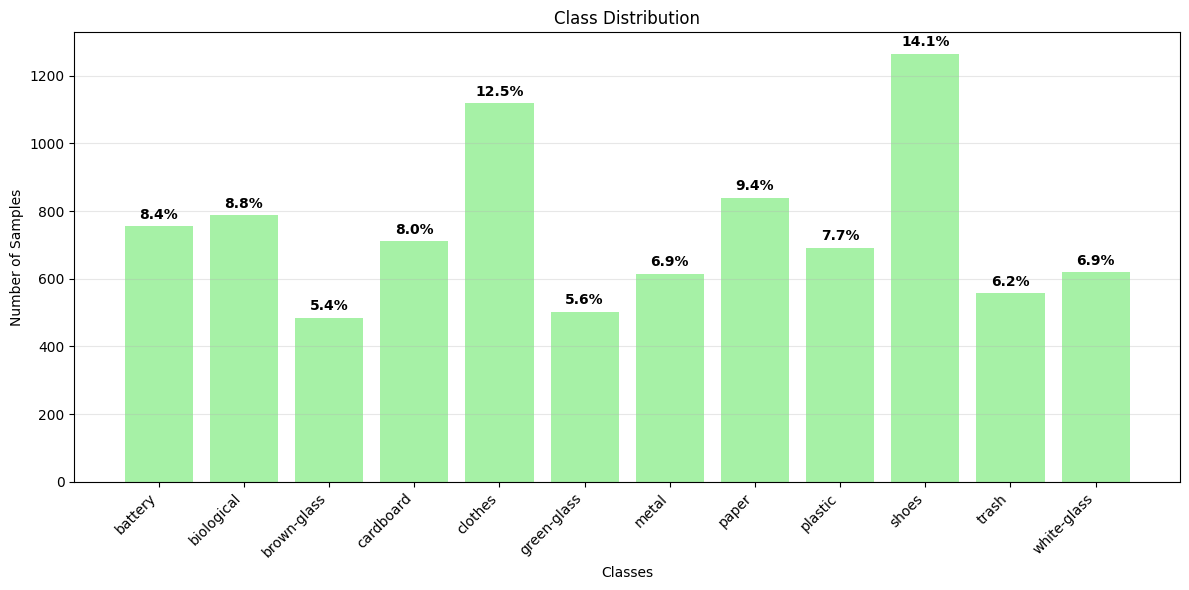

In [10]:
# This is a bit tricky. Two main reasons:
# 1. if we remove items from 1 class, we reduce the total number of items in the dataset,
#  and the ratio of the other classes will change, possible exceeded the 15% limit.
# 2. if we iterate over the classes, we might end up removing to many items from a class.
# we need to remove in small batches to avoid reducing too much. 
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def plot_balanced_class_distribution(train_dataset, classes_names):
    """
    Simple class distribution plot with class names and percentages.
    
    Args:
        train_dataset: The dataset (Subset or regular dataset)
        classes_names: List of class names for labeling
    """

    labels = [train_dataset.dataset[i][1] for i in train_dataset.indices]
    
    # Count occurrences and calculate percentages
    class_counts = Counter(labels)
    total_samples = len(labels)
    
    # Create ordered lists matching classes_names order
    counts = [class_counts[i] for i in range(len(classes_names))]
    percentages = [count/total_samples*100 for count in counts]
    
    # Create the plot
    x = np.arange(len(classes_names))
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, counts, alpha=0.8, color='lightgreen')
    
    # Add percentage labels on top of bars
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        plt.text(i, count + max(counts)*0.01, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.title(f'Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(x, classes_names, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

def downsample_training_dataset(train_dataset, max_percentage=0.15):
    current_indices = train_dataset.indices.copy()
    original_dataset = train_dataset.dataset
    
    max_iterations = 10
    iteration = 0
    
    while iteration < max_iterations:
        # Get current distribution
        current_labels = [original_dataset[i][1] for i in current_indices]
        label_counts = Counter(current_labels)
        total_samples = len(current_indices)
        
        # Find the most overrepresented class
        max_violation = 0
        worst_class = None
        
        for label, count in label_counts.items():
            current_percentage = count / total_samples
            if current_percentage > max_percentage:
                violation = current_percentage - max_percentage
                if violation > max_violation:
                    max_violation = violation
                    worst_class = label
        
        # If no violations, we're done
        if worst_class is None:
            print(f"Converged after {iteration} iterations")
            break
        
        # Remove just a small batch from the worst class
        class_indices = [idx for idx in current_indices 
                        if original_dataset[idx][1] == worst_class]
        
        # Remove smaller chunks - either 5% of class or minimum 1 sample
        remove_count = max(10, int(len(class_indices) * 0.2))  # Remove 20% or at least 10
        
        if len(class_indices) > remove_count:
            np.random.shuffle(class_indices)
            indices_to_remove = set(class_indices[:remove_count])
            current_indices = [idx for idx in current_indices 
                             if idx not in indices_to_remove]
        
        iteration += 1
    
    # Return a new Subset with the downsampled indices
    return Subset(original_dataset, current_indices)

MAX_PERCENTAGE = 0.15
balanced_train_dataset = downsample_training_dataset(train_dataset, MAX_PERCENTAGE)
plot_balanced_class_distribution(balanced_train_dataset, classes_names)

## Implementation of Regularization Layers

Implement two regularization layers from scratch:
1. `BatchNorm2d`
2. `LayerNorm`

Make sure that all trainable parameters (such as scale and shift) are properly registered as part of the computational graph, so they are optimized during training.


### TODO 5:
Implement the BatchNorm2d layer from scratch using only basic PyTorch components (such as `nn.Module` and tensor operations), without relying on `nn.BatchNorm2d`.


In [11]:
class BatchNorm2d(nn.Module):
    """
    Batch Normalization for images
    
    Normalizes inputs across the batch and spatial dimensions, 
    but keeps channels separate.
    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        
        # Scale parameter (gamma) - initially set to 1
        self.gamma = nn.Parameter(torch.ones(num_features))
        # Shift parameter (beta) - initially set to 0  
        self.beta = nn.Parameter(torch.zeros(num_features))
        
        # Running statistics for inference (not trainable parameters)
        # These track the overall dataset statistics during training
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        
    def forward(self, x):
        """
        Forward pass of BatchNorm2d
        
        Args:
            x: Input tensor of shape (N, C, H, W)
               N = batch size, C = channels, H = height, W = width
        
        Returns:
            Normalized and scaled tensor of same shape
        """
        # During training: use current batch statistics
        if self.training:
            # Calculate mean and variance across batch and spatial dimensions
            # Keep only the channel dimension (dim=1)
            batch_mean = x.mean(dim=[0, 2, 3])  # Shape: (C,)
            batch_var = x.var(dim=[0, 2, 3], unbiased=False)  # Shape: (C,)
            
            # Update running statistics for inference
            # Use exponential moving average
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
            
            # Use current batch statistics for normalization
            mean = batch_mean
            var = batch_var
            
        # During inference: use running statistics
        else:
            mean = self.running_mean
            var = self.running_var
        
        # Normalize: (x - mean) / sqrt(var + eps)
        # Reshape mean and var to broadcast correctly: (1, C, 1, 1)
        mean = mean.view(1, -1, 1, 1)
        var = var.view(1, -1, 1, 1)
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        
        # Scale and shift: gamma * x_normalized + beta
        # Reshape gamma and beta for broadcasting: (1, C, 1, 1)
        gamma = self.gamma.view(1, -1, 1, 1)
        beta = self.beta.view(1, -1, 1, 1)
        
        output = gamma * x_normalized + beta
        
        return output

### TODO 6:
Implement the LayerNorm layer from scratch using only basic PyTorch components (such as `nn.Module` and tensor operations), without relying on `nn.LayerNorm`.


In [68]:
class LayerNorm(nn.Module):
    """
    Simple Layer Normalization for conv layers.
    
    Normalizes over spatial dimensions (H, W) for each channel separately.
    This is more stable than normalizing over all dimensions.
    """
    def __init__(self, num_channels, eps=1e-5):
        super(LayerNorm, self).__init__()
        
        self.eps = eps
        
        # Scale and shift parameters - one per channel
        self.gamma = nn.Parameter(torch.ones(num_channels))
        self.beta = nn.Parameter(torch.zeros(num_channels))
        
    def forward(self, x):
        """
        Forward pass of LayerNorm
        
        Args:
            x: Input tensor of shape (N, C, H, W)
        
        Returns:
            Normalized tensor of same shape
        """
        # Normalize over spatial dimensions (H, W) for each channel
        mean = x.mean(dim=[2, 3], keepdim=True)  # Shape: (N, C, 1, 1)
        var = x.var(dim=[2, 3], keepdim=True, unbiased=False)  # Shape: (N, C, 1, 1)
        
        # Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        # Apply scale and shift per channel
        gamma = self.gamma.view(1, -1, 1, 1)
        beta = self.beta.view(1, -1, 1, 1)
        
        return gamma * x_norm + beta

## Traning 

### TODO 7:
Complete the `GarbageClassifier` neural network by designing and implementing an architecture of your choice.  
Make use of the provided `_block` and `_block_mp` building blocks as you see fit.  
Allow the regularization type (e.g., `BatchNorm2d` or `LayerNorm`) to be specified from outside the class, so you can later compare the results between the two types of regularization.


In [104]:
class GarbageClassifier(nn.Module):
    def __init__(self, num_classes, norm_layer=None):
        super(GarbageClassifier, self).__init__()
        self.norm_layer = norm_layer
        self.num_classes = num_classes
        
        self.features = nn.Sequential(
            self._block_mp(3, 96, kernel_size=7, stride=2, padding=3, norm_layer=self.norm_layer, kernel_size_mp=2),
            self._block_mp(96, 256, kernel_size=3, stride=1, padding=1, norm_layer=self.norm_layer, kernel_size_mp=2),
            self._block(256, 384, kernel_size=3, stride=1, padding=1, norm_layer=self.norm_layer),
            self._block(384, 384, kernel_size=3, stride=1, padding=1, norm_layer=self.norm_layer),
            self._block_mp(384, 256, kernel_size=3, stride=1, padding=1, norm_layer=self.norm_layer, kernel_size_mp=2),
        )

        self.classifier = nn.Sequential(
          nn.AdaptiveAvgPool2d((6, 6)),
          nn.Flatten(),
          nn.Dropout(0.5),
          nn.Linear(9216, 4096),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Linear(4096, num_classes))

       
    def _block_mp(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None, kernel_size_mp=2):
        """AlexNet style block with max pooling"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels), # Normalization layer that you have implemented
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=kernel_size_mp)
        )

    def _block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, norm_layer=None):
        """AlexNet style block without max pooling"""

        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.ReLU(inplace=True)
        )
    

    def forward(self, x):
        # Forward pass through the feature extractor givven self.features and self.classifier
        x = self.features(x)
        x = self.classifier(x)
        return x

### TODO 8:
Prepare all components needed for training:
1. Build your neural network with one type of regularization.
2. Create DataLoaders for the training (and optionally validation) sets.
3. Define the loss criterion.
4. Define the optimizer and assign it the trainable parameters of your model.
5. Print a summary of your network architecture.


In [110]:
from torch.utils.data import DataLoader

#1. Define Hyperparameters
learning_rate = 0.0001
epochs = 10
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#2. Set up the mode1
model = GarbageClassifier(num_classes=12, norm_layer=BatchNorm2d)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#3. Create data loaders
train_data_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
test_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### TODO 9:
Write a training loop to train your network for 10 epochs using the training set.
- Track and print the training loss for each epoch.
- After each epoch, compute and store both the loss and accuracy on the test set.
- After training, plot both the training and test losses on the same graph to visualize the learning process.
- Your model should achieve at least 75% accuracy on the test set.
- Remember to set your model to training mode (`model.train()`) during training, and to evaluation mode (`model.eval()`) when computing metrics on the test set.


In [112]:
def train_model(model, train_data_loader, test_data_loader, optimizer, loss_fn, device, epochs):
    # Track losses for plotting
    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0  # Track the loss for each epoch

        for images, labels in tqdm(train_data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradient buffers
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model weights

            running_loss += loss.item()  # Accumulate loss

        # Print training loss for the epoch
        train_loss = running_loss/len(train_data_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")
        
        # After the training loop for one epoch, evaluate on TEST set
        model.eval()  # Set model to evaluation mode
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # No need to track gradients for evaluation
            for images, labels in test_data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_loss_avg = test_loss/len(test_data_loader)
        print(f"Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.2f}%") 

        scheduler.step()

        train_losses.append(train_loss)
        test_losses.append(test_loss_avg)
        test_accuracies.append(test_accuracy)

    return train_losses, test_losses, test_accuracies

def plot_learning_curves(epochs, train_losses, test_losses, test_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")



In [113]:
train_losses, test_losses, test_accuracies = train_model(model, train_data_loader, test_data_loader, optimizer, loss_fn, device, epochs)

Epoch 1/10: 100%|██████████| 280/280 [00:10<00:00, 26.32it/s]

Epoch [1/10], Training Loss: 1.5820


Test Loss: 1.2777, Test Accuracy: 58.11%


Epoch 2/10: 100%|██████████| 280/280 [00:10<00:00, 26.38it/s]

Epoch [2/10], Training Loss: 1.1922


Test Loss: 1.2529, Test Accuracy: 59.56%


Epoch 3/10: 100%|██████████| 280/280 [00:10<00:00, 26.26it/s]

Epoch [3/10], Training Loss: 1.0222


Test Loss: 1.0510, Test Accuracy: 66.19%


Epoch 4/10: 100%|██████████| 280/280 [00:10<00:00, 26.36it/s]

Epoch [4/10], Training Loss: 0.7868


Test Loss: 0.7236, Test Accuracy: 76.14%


Epoch 5/10: 100%|██████████| 280/280 [00:10<00:00, 26.43it/s]

Epoch [5/10], Training Loss: 0.7120


Test Loss: 0.6948, Test Accuracy: 77.53%


Epoch 6/10: 100%|██████████| 280/280 [00:10<00:00, 26.22it/s]

Epoch [6/10], Training Loss: 0.6554


Test Loss: 0.6572, Test Accuracy: 78.40%


Epoch 7/10: 100%|██████████| 280/280 [00:10<00:00, 26.23it/s]

Epoch [7/10], Training Loss: 0.6165


Test Loss: 0.6565, Test Accuracy: 78.36%


Epoch 8/10: 100%|██████████| 280/280 [00:10<00:00, 26.20it/s]

Epoch [8/10], Training Loss: 0.6044


Test Loss: 0.6569, Test Accuracy: 78.65%


Epoch 9/10: 100%|██████████| 280/280 [00:10<00:00, 26.36it/s]

Epoch [9/10], Training Loss: 0.5942


Test Loss: 0.6534, Test Accuracy: 78.56%


Epoch 10/10: 100%|██████████| 280/280 [00:10<00:00, 26.44it/s]

Epoch [10/10], Training Loss: 0.5926


Test Loss: 0.6513, Test Accuracy: 78.59%


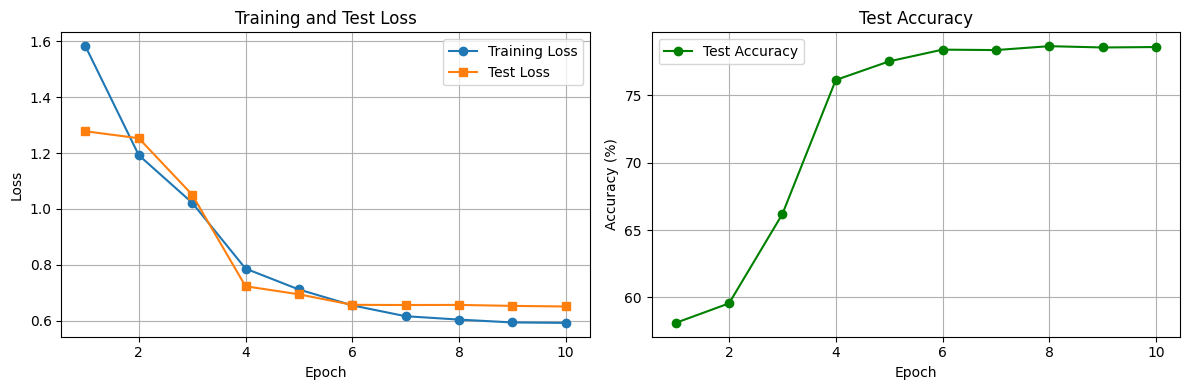


Final Test Accuracy: 78.59%


In [114]:
plot_learning_curves(epochs, train_losses, test_losses, test_accuracies)

### TODO 10:
Compute and report the accuracy of your trained model on the test set for each individual category (class).

For example:
* Class battery: 80%
* Class biological: 71%
* Class brown-glass: 70%
* Class cardboard: 85%
* Class clothes: 92%
* Class green-glass: 88%
* Class metal: 43%
* Class paper: 54%
* Class plastic: 39%
* Class shoes: 71%
* Class trash: 68%
* Class white-glass: 55%


In [115]:
def evaluate_per_class_accuracy(model, test_data_loader, class_names, device):
    """
    Calculate how well the model performs on each individual class.
    
    Args:
        model: The trained neural network
        test_data_loader: DataLoader containing test images and labels
        class_names: List of class names (e.g., ['plastic', 'glass', 'metal', ...])
        device: 'cuda' or 'cpu' - where to run the model
    
    Returns:
        Nothing - prints accuracy for each class
    """
    
    model.eval()
    
    number_of_classes = len(class_names)
    correct_predictions_per_class = [0] * number_of_classes
    total_samples_per_class = [0] * number_of_classes
    
    with torch.no_grad(): #no need to track gradients for evaluation
        for batch_images, batch_labels in test_data_loader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            model_outputs = model(batch_images)  # Raw prediction scores for each class
            
            _, predicted_classes = torch.max(model_outputs, 1) # Get predicted classes
            
            batch_size = batch_labels.size(0)  # Get number of images in batch
            
            for sample_index in range(batch_size):
                true_class = batch_labels[sample_index].item()
                predicted_class = predicted_classes[sample_index].item()
                
                total_samples_per_class[true_class] += 1
                
                if predicted_class == true_class:
                    correct_predictions_per_class[true_class] += 1
    
    print("\n=== Per-Class Accuracy Results ===")
    print("-" * 40)
    
    for class_index, class_name in enumerate(class_names):
        if total_samples_per_class[class_index] > 0:
            correct_count = correct_predictions_per_class[class_index]
            total_count = total_samples_per_class[class_index]
            accuracy_percentage = (correct_count / total_count) * 100
            
            print(f"Class '{class_name}': {accuracy_percentage:.1f}% "
                  f"({correct_count}/{total_count} correct)")
        else:
            print(f"Class '{class_name}': No samples found in test data")
    
    print("-" * 40)

evaluate_per_class_accuracy(model, test_data_loader, classes_names, device)


=== Per-Class Accuracy Results ===
----------------------------------------
Class 'battery': 72.5% (137/189 correct)
Class 'biological': 74.6% (147/197 correct)
Class 'brown-glass': 80.3% (98/122 correct)
Class 'cardboard': 78.2% (140/179 correct)
Class 'clothes': 89.1% (949/1065 correct)
Class 'green-glass': 95.2% (120/126 correct)
Class 'metal': 57.1% (88/154 correct)
Class 'paper': 82.4% (173/210 correct)
Class 'plastic': 50.3% (87/173 correct)
Class 'shoes': 75.8% (300/396 correct)
Class 'trash': 72.1% (101/140 correct)
Class 'white-glass': 65.2% (101/155 correct)
----------------------------------------


### Repeat TODOs 8,9 and 10 with the other type of regularization

Repeat the previous steps for preparing your model, DataLoaders, optimizer, and training loop, but this time using the alternative regularization layer. After training, compare the performance between the two regularization types.


In [73]:
# Add this before creating the LayerNorm model
torch.cuda.empty_cache()

# Clear any previous models from GPU
if 'model' in locals():
    del model
torch.cuda.empty_cache()

Epoch 1/10: 100%|██████████| 140/140 [00:05<00:00, 23.51it/s]

Epoch [1/10], Training Loss: 2.0019


Test Loss: 1.4048, Test Accuracy: 52.19%


Epoch 2/10: 100%|██████████| 140/140 [00:06<00:00, 23.25it/s]

Epoch [2/10], Training Loss: 1.4540


Test Loss: 1.0700, Test Accuracy: 64.01%


Epoch 3/10: 100%|██████████| 140/140 [00:05<00:00, 23.53it/s]

Epoch [3/10], Training Loss: 1.2189


Test Loss: 1.1090, Test Accuracy: 62.81%


Epoch 4/10: 100%|██████████| 140/140 [00:05<00:00, 23.85it/s]

Epoch [4/10], Training Loss: 1.0287


Test Loss: 1.0096, Test Accuracy: 65.97%


Epoch 5/10: 100%|██████████| 140/140 [00:05<00:00, 23.48it/s]

Epoch [5/10], Training Loss: 0.9250


Test Loss: 1.0141, Test Accuracy: 67.16%


Epoch 6/10: 100%|██████████| 140/140 [00:05<00:00, 23.65it/s]

Epoch [6/10], Training Loss: 0.8317


Test Loss: 0.8257, Test Accuracy: 72.63%


Epoch 7/10: 100%|██████████| 140/140 [00:05<00:00, 23.72it/s]

Epoch [7/10], Training Loss: 0.7054


Test Loss: 0.7937, Test Accuracy: 74.31%


Epoch 8/10: 100%|██████████| 140/140 [00:05<00:00, 23.50it/s]

Epoch [8/10], Training Loss: 0.6237


Test Loss: 0.8188, Test Accuracy: 73.54%


Epoch 9/10: 100%|██████████| 140/140 [00:05<00:00, 23.48it/s]

Epoch [9/10], Training Loss: 0.5700


Test Loss: 0.9421, Test Accuracy: 72.70%


Epoch 10/10: 100%|██████████| 140/140 [00:05<00:00, 23.68it/s]

Epoch [10/10], Training Loss: 0.4856


Test Loss: 0.8035, Test Accuracy: 76.34%


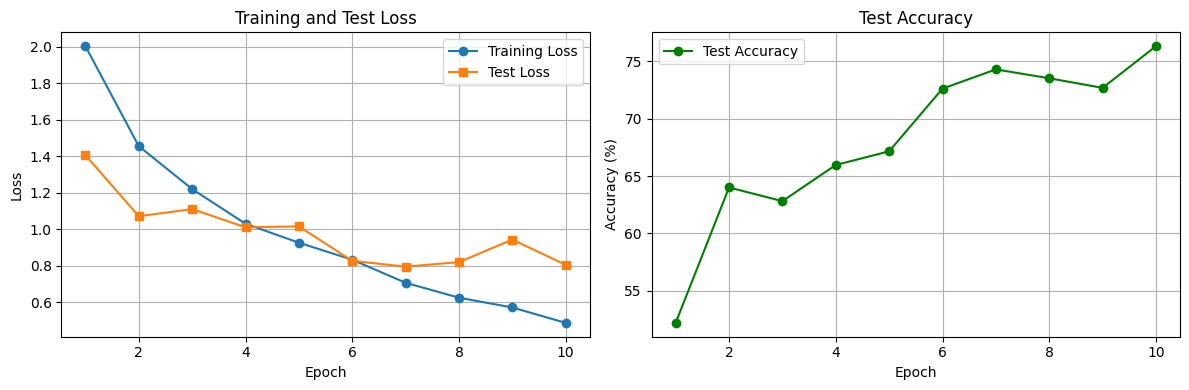


Final Test Accuracy: 76.34%

=== Per-Class Accuracy Results ===
----------------------------------------
Class 'battery': 64.0% (121/189 correct)
Class 'biological': 71.6% (141/197 correct)
Class 'brown-glass': 83.6% (102/122 correct)
Class 'cardboard': 65.9% (118/179 correct)
Class 'clothes': 89.9% (957/1065 correct)
Class 'green-glass': 92.9% (117/126 correct)
Class 'metal': 54.5% (84/154 correct)
Class 'paper': 74.8% (157/210 correct)
Class 'plastic': 43.4% (75/173 correct)
Class 'shoes': 75.0% (297/396 correct)
Class 'trash': 70.7% (99/140 correct)
Class 'white-glass': 66.5% (103/155 correct)
----------------------------------------


In [107]:
#1. Define Hyperparameters
learning_rate = 0.0025
epochs = 10
batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#2. Set up the mode1
layer_norm_model = GarbageClassifier(num_classes=12, norm_layer=LayerNorm)
layer_norm_model = layer_norm_model.to(device)
layer_norm_optimizer = torch.optim.SGD(layer_norm_model.parameters(), lr=learning_rate, momentum=0.95, weight_decay=1e-4)
layer_norm_loss_fn = nn.CrossEntropyLoss()
layer_norm_scheduler = torch.optim.lr_scheduler.StepLR(layer_norm_optimizer, step_size=3, gamma=0.6)

#3. Create data loaders
layer_norm_train_data_loader = DataLoader(balanced_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
layer_norm_test_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#4. Train the model
layer_norm_train_losses, layer_norm_test_losses, layer_norm_test_accuracies = train_model(layer_norm_model, layer_norm_train_data_loader, layer_norm_test_data_loader, layer_norm_optimizer, layer_norm_loss_fn, device, epochs)

#5. Plot the learning curves
plot_learning_curves(epochs, layer_norm_train_losses, layer_norm_test_losses, layer_norm_test_accuracies)

#6. Evaluate the model
evaluate_per_class_accuracy(layer_norm_model, layer_norm_test_data_loader, classes_names, device)

### Final Task: Summary and Analysis

Write a summary of your work and the results you obtained. In 3–4 paragraphs, discuss your approach, key findings, and any challenges you encountered. Compare the performance of the two different regularization techniques you implemented, and suggest possible reasons for any differences you observed. Reflect on what you learned and what you might try differently in future experiments.


Good luck!